In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling
import selex_dca, utils

/home/scrotti/Aptamer2025py/experiments/../sampling.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
round_ids = ['Input_R1_N', 'OplusR1_N', 'OplusR2_N']

dtype = torch.float32

In [3]:
sequences = []
for round_id in round_ids:
    sequences.append(utils.sequences_from_file_ab6(round_id))

In [4]:
sequences_oh = [utils.one_hot(seq, num_classes=21) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [5]:
tr = tree.Tree()
tr.add_node(-1, name = 'OplusR1_N')
tr.add_node(0, name = 'OplusR2_N')

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [6]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
device = torch.device('cpu')

In [7]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [8]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype).to(device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype).to(device)

In [9]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [10]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 200

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights, lr=lr)

 0.00%[                                                                                                       …

KeyboardInterrupt: 

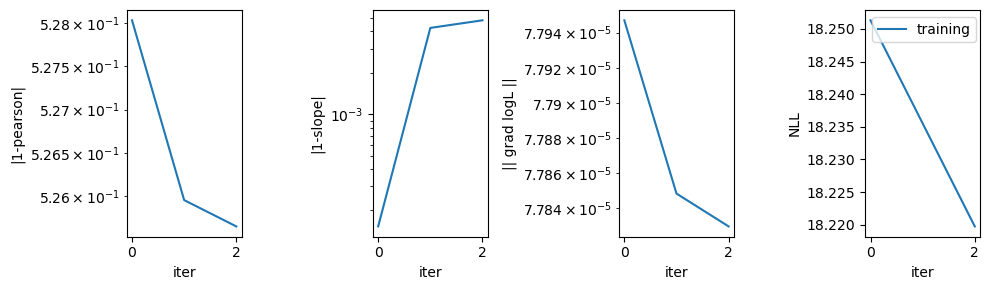

In [11]:
callbacks[0].plot();

(<Figure size 800x300 with 2 Axes>,
 <Axes: xlabel='iter', ylabel='|1 - slope|'>)

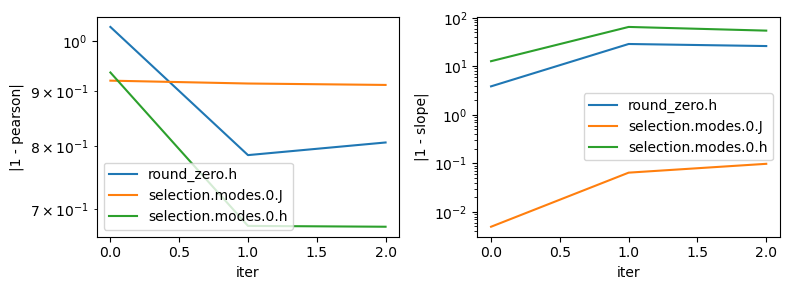

In [14]:
callbacks[0].plot_pearson_detail(figsize=(8,3))

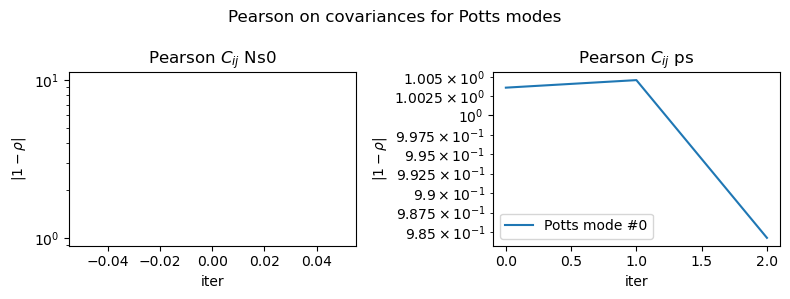

In [15]:
fig, ax = callbacks[1].plot(figsize=(8,3))

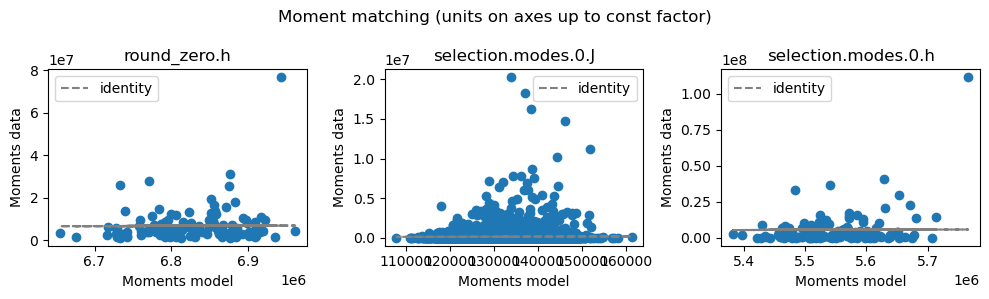

In [16]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

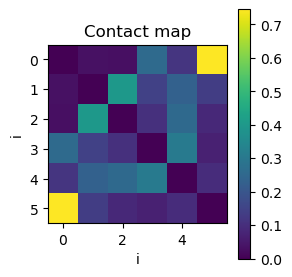

In [58]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
plt.title('Contact map');
# display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [59]:
(h ** 2).sum(1)

tensor([20.6719,  3.6309,  3.7012,  5.4479,  5.1432, 11.0408])